In [2]:
import os, sys
PROJECT_ROOT = os.path.abspath(os.path.dirname(sys.path[0]))
sys.path.append(PROJECT_ROOT)

from lsr_tensor import *
from lsr_bcd_regression import *
import torch
import torch.nn.functional as f
from datasets import *
from federated_algos import *
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
from federated_tests import *
from medmnist import BreastMNIST, VesselMNIST3D
import cProfile
from torchvision import transforms

In [35]:
# Synthetic Data
shape, ranks, separation_rank = (64, 64), (8, 8), 2
loss_fn = f.mse_loss

sample_size = 2000
val_sample_size = 500

synth_dataset, synth_val_dataset = synthesize_data(shape, ranks, separation_rank,\
                                                   sample_size, val_sample_size)
synth_client_datasets = federate_dataset(synth_dataset, 10)
synth_data = (synth_dataset, synth_client_datasets, synth_val_dataset)

In [2]:
# Breast MNIST
shape, ranks, separation_rank = (28, 28), (3, 3), 2
loss_fn = logistic_loss

transform = transforms.Compose([transforms.PILToTensor(), transforms.ConvertImageDtype(torch.float32)])

breast_dataset = BreastMNIST(split="train", download=True, transform=transform)
breast_client_datasets = federate_dataset(breast_dataset, 10)
breast_val_dataset = BreastMNIST(split="val", download=True, transform=transform)
breast_data = (breast_dataset, breast_client_datasets, breast_val_dataset)

print("fraction positive: ", sum(breast_val_dataset[:, 0][1]) / len(breast_val_dataset[:, 0][1]))

Using downloaded and verified file: /home/fishcat/.medmnist/breastmnist.npz
Using downloaded and verified file: /home/fishcat/.medmnist/breastmnist.npz
fraction positive:  0.7307692307692307


In [3]:
# Vessel MNIST 3D
vessel_dataset = VesselMNIST3D(split="train", download=True)
vessel_val_dataset = VesselMNIST3D(split="val", download=True)
vessel_client_datasets = federate_dataset(vessel_dataset, 10)
vessel_data = (vessel_dataset, vessel_client_datasets, vessel_val_dataset)
print([len(c) for c in vessel_client_datasets])
print("fraction positive: ", sum(vessel_val_dataset[:, 0][1]) / len(vessel_val_dataset[:, 0][1]))

Using downloaded and verified file: /home/fishcat/.medmnist/vesselmnist3d.npz
Using downloaded and verified file: /home/fishcat/.medmnist/vesselmnist3d.npz
[166, 167, 167, 167, 167, 167, 167, 167]
fraction positive:  0.11458333333333333


In [33]:
iters = 100
n_workers = 4
n_runs = 4

path_base = "../data/vessel_tuning"
dataset, client_datasets, val_dataset = vessel_data
loss_fn = logistic_loss
aggregator_fn = avg_aggregation

shape, ranks, separation_rank = (28, 28, 28), (3, 3, 3), 2
steps = 10
lr = 0.001
momentum = 0.99

hypers = {"max_rounds": 1, "max_iter": iters, "batch_size": None, "lr": lr, "momentum": momentum, "steps": steps, "threshold": 0.0}
lsr_dot_params = (shape, ranks, separation_rank, torch.float64, torch.device('cuda'))

print(f"Training lr {lr} steps {steps} momentum {momentum}")
path = f"{path_base}/lr{int(lr*1000)}_mom{momentum}_steps{steps}"
args = (lsr_bcd_regression, lsr_dot_params, loss_fn, dataset, val_dataset, hypers, True)

run_test(path, n_runs, n_workers, *args)
        

Training lr 0.1 steps 10 momentum 0.0
Run 0
Run 1
Run 2
Run 3
Training lr 0.1 steps 10 momentum 0.9
Run 0


Process SpawnPoolWorker-388:
Traceback (most recent call last):
  File "/usr/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/usr/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/usr/lib/python3.8/multiprocessing/pool.py", line 51, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
  File "/home/fishcat/Federated-LSRTR/federated_tests.py", line 13, in run_trial
    final_lsr_dot, perf_info = method(init_tensor_dot, *args)
  File "/home/fishcat/Federated-LSRTR/lsr_bcd_regression.py", line 63, in lsr_bcd_regression
    x_combined = lsr_ten.bcd_factor_update_x(s, k, X)
  File "/home/fishcat/.local/lib/python3.8/site-packages/torch/utils/_contextlib.py", line 115, in decorate_context
    return func(*args, **kwargs)
  File "/home/fishcat/Federated-LSRTR/l

KeyboardInterrupt: 

In [37]:
iters = 100
n_workers = 8
n_runs = 4
path_base = "../data/synth_test"

dataset, client_datasets, val_dataset = synth_data
loss_fn = f.mse_loss
aggregator_fn = avg_aggregation
hypers = {"max_rounds": 1, "max_iter": iters, "batch_size": None, "lr": 0.001, "momentum": 0.9, "steps": 10, "threshold": 0.0}

lsr_dot_params = ((64, 64), (8, 8), 2, torch.float32, torch.device('cuda'))

print("Centralized algorithm training")
path = f"{path_base}/centralized"
args = (lsr_bcd_regression, lsr_dot_params, loss_fn, dataset, val_dataset, hypers, False)

run_test(path, n_runs, n_workers, *args)

print("\nStepwise federated algorithm training...")
path = f"{path_base}/step"
args = (BCD_federated_stepwise, lsr_dot_params, client_datasets, val_dataset,\
        hypers, loss_fn, aggregator_fn, False)

run_test(path, n_runs, n_workers, *args)

print("\nSplit factors + core federated algorithm training...")
path = f"{path_base}/factors_core"
args = (BCD_federated_all_factors, lsr_dot_params, client_datasets, val_dataset,\
        hypers, loss_fn, aggregator_fn, False)

run_test(path, n_runs, n_workers, *args)

print("\n1 full iteration federated algorithm training...")
path = f"{path_base}/one_iter"
hypers["max_rounds"], hypers["max_iter"] = iters, 1
args = (BCD_federated_full_iteration, lsr_dot_params, client_datasets, val_dataset,\
        hypers, loss_fn, aggregator_fn, False)

run_test(path, n_runs, n_workers, *args)

print("\n5 full iteration federated algorithm training...")
path = f"{path_base}/five_iter"
hypers["max_rounds"], hypers["max_iter"] = iters // 5, 5
args = (BCD_federated_full_iteration, lsr_dot_params, client_datasets, val_dataset,\
        hypers, loss_fn, aggregator_fn, False)

run_test(path, n_runs, n_workers, *args)

Centralized algorithm training
Run 0
Run 1
Run 2
Run 3

Stepwise federated algorithm training...
Run 0
Run 1
Run 2
Run 3

Split factors + core federated algorithm training...
Run 0
Run 1
Run 2
Run 3

1 full iteration federated algorithm training...
Run 0
Run 1
Run 2
Run 3

5 full iteration federated algorithm training...
Run 0
Run 1
Run 2
Run 3


In [40]:
#Load data from runs
path_base = "../data/synth_test"
names = ["centralized", "step", "factors_core", "one_iter", "five_iter"]
#names = [f"lr{int(lr*1000)}_mom{momentum}" for momentum in [0.0, 0.9, 0.99] for lr in [0.1, 0.003, 0.001]]

train_losses, train_std = [], []
val_losses, val_std = [], []

train_accs, train_acc_std = [], []
val_accs, val_acc_std = [], []

for name in names:
    path = f"{path_base}/{name}"
    train_losses.append(torch.mean(torch.load(f"{path}/train_loss"), axis=0))
    train_std.append(torch.std(torch.load(f"{path}/train_loss"), axis=0))
    
    val_losses.append(torch.mean(torch.load(f"{path}/val_loss"), axis=0))
    val_std.append(torch.std(torch.load(f"{path}/val_loss"), axis=0))

    #train_accs.append(torch.mean(torch.load(f"{path}/train_acc"), axis=0))
    #train_acc_std.append(torch.std(torch.load(f"{path}/train_acc"), axis=0))
    
    #val_accs.append(torch.mean(torch.load(f"{path}/val_acc"), axis=0))
    #val_acc_std.append(torch.std(torch.load(f"{path}/val_acc"), axis=0))
    
print("Loaded run data")

Loaded run data


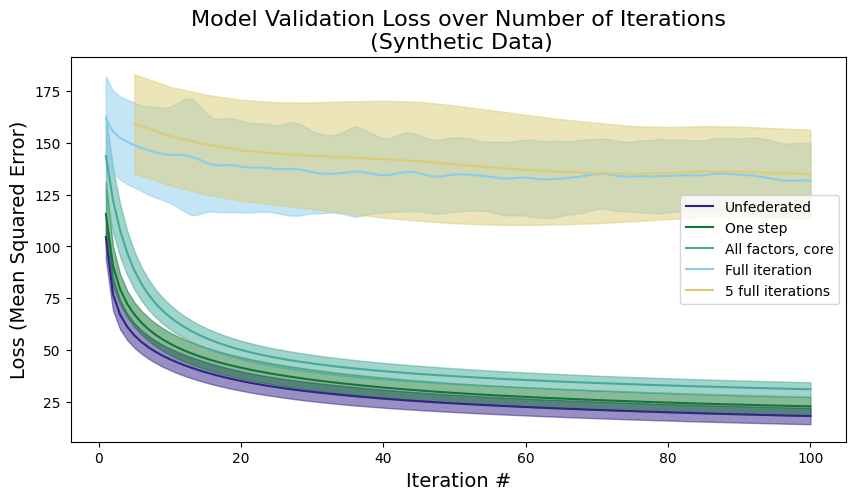

In [43]:
colors = ["#332288", "#117733", "#44AA99", "#88CCEE", "#DDCC77", "#CC6677", "#AA4499", "#882255", "#5D070A"]
labels = ["Unfederated", "One step", "All factors, core", "Full iteration", "5 full iterations"]
#labels = names

xscales = [1, 1, 1, 1, 5]
#xscales = [1, 1, 1, 1, 1, 1]
#xscales = [1, 1, 1, 1, 1, 1]

metrics = val_losses
stds = val_std

plt.figure(figsize=(10, 5))
for metric, std, xscale, label, color in zip(metrics, stds, xscales, labels, colors):
    plt.plot((np.arange(len(metric)) + 1)*xscale, metric, label=label, color=color)
    plt.fill_between((np.arange(len(metric)) + 1)*xscale, metric-std, metric+std, color=color, alpha=0.5)

plt.legend()
plt.xlabel("Iteration #", fontsize=14)
plt.ylabel("Loss (Mean Squared Error)", fontsize=14)
plt.title("Model Validation Loss over Number of Iterations\n (Synthetic Data)", fontsize=16)
plt.show()

In [50]:
print("Testing...")

hypers = {"max_rounds": 1, "max_iter": 100, "batch_size": None, "lr": 0.001, "momentum": 0.9, "steps": 10, "threshold": 0.0}
aggregator_fn = logistic_loss
lsr_dot_params = (shape, (3, 3, 3), 2, torch.float64, torch.device('cuda'))

init_lsr_dot = LSR_tensor_dot(*lsr_dot_params)
lsr_bcd_regression(init_lsr_dot, loss_fn, vessel_dataset, vessel_val_dataset,\
                       hypers, True, True)

print("Finished without errors")

Testing...
Iteration 0 | Validation Loss: 0.8519310806858168
Iteration 1 | Validation Loss: 0.8358541462734985
Iteration 2 | Validation Loss: 0.8199724511048121
Iteration 3 | Validation Loss: 0.8043566506752905
Iteration 4 | Validation Loss: 0.789112438084739
Iteration 5 | Validation Loss: 0.7743623899615001
Iteration 6 | Validation Loss: 0.7602304229439147
Iteration 7 | Validation Loss: 0.7468291337772792
Iteration 8 | Validation Loss: 0.7342504387555979
Iteration 9 | Validation Loss: 0.722559701167045
Iteration 10 | Validation Loss: 0.7117931560640702
Iteration 11 | Validation Loss: 0.7019580938603491
Iteration 12 | Validation Loss: 0.6930350598550654
Iteration 13 | Validation Loss: 0.6849812938902673
Iteration 14 | Validation Loss: 0.6777347374882441
Iteration 15 | Validation Loss: 0.6712181123700178
Iteration 16 | Validation Loss: 0.6653427660531996
Iteration 17 | Validation Loss: 0.6600121492765931
Iteration 18 | Validation Loss: 0.6551249195754738
Iteration 19 | Validation Loss: 

In [5]:
# Performance testing
print("Performance Testing...")
hypers = {"max_rounds": 1, "max_iter": 100, "batch_size": None, "lr": 0.005, "momentum": 0.9, "steps": 10, "threshold": 0.0}
aggregator_fn = avg_aggregation
lsr_dot_params = (shape, ranks, separation_rank, torch.float32, torch.device('cuda'))
init_lsr_dot = LSR_tensor_dot(*lsr_dot_params)
cProfile.run("BCD_federated_stepwise(init_lsr_dot, synth_client_datasets, synth_val_dataset,\
              hypers, loss_fn, aggregator_fn, False)", sort='tottime')

Performance Testing...
         13343346 function calls (12668211 primitive calls) in 33.173 seconds

   Ordered by: internal time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
    43930    6.503    0.000    6.503    0.000 {method 'run_backward' of 'torch._C._EngineBase' objects}
    44887    2.267    0.000    2.267    0.000 {built-in method torch._C._nn.mse_loss}
    83467    2.150    0.000    2.150    0.000 {built-in method torch._foreach_add_}
   222321    2.095    0.000    2.095    0.000 {built-in method torch.reshape}
    39537    1.862    0.000    1.862    0.000 {built-in method torch._foreach_mul_}
    59275    1.337    0.000    1.337    0.000 {built-in method torch.matmul}
    88044    0.828    0.000    0.828    0.000 {built-in method torch._ops.profiler._record_function_enter_new}
    38720    0.722    0.000    0.722    0.000 {built-in method torch.cat}
    43930    0.648    0.000    0.648    0.000 {built-in method torch.ones_like}
    98582    0.621

KeyboardInterrupt: 